In [1]:
#!pip install --user logomaker

In [20]:
from Bio import SeqIO
import bioframe as bf
import gzip
import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
from scipy.stats import entropy
import seaborn as sns
from io import StringIO

In [2]:
nucleotides = ["A", "C", "G", "T"]

In [3]:
with gzip.open("../../data/mlm/genome/Arabidopsis_thaliana.fa.gz", "rt") as handle:
    genome = SeqIO.to_dict(SeqIO.parse(handle, "fasta"))
genome = {k: v.upper() for k, v in genome.items()}
genome

{'1': SeqRecord(seq=Seq('CCCTAAACCCTAAACCCTAAACCCTAAACCTCTGAATCCTTAATCCCTAAATCC...GGG'), id='1', name='1', description='1 dna_sm:chromosome chromosome:TAIR10:1:1:30427671:1 REF', dbxrefs=[]),
 '2': SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...GGG'), id='2', name='2', description='2 dna_sm:chromosome chromosome:TAIR10:2:1:19698289:1 REF', dbxrefs=[]),
 '3': SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...CCC'), id='3', name='3', description='3 dna_sm:chromosome chromosome:TAIR10:3:1:23459830:1 REF', dbxrefs=[]),
 '4': SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...AGG'), id='4', name='4', description='4 dna_sm:chromosome chromosome:TAIR10:4:1:18585056:1 REF', dbxrefs=[]),
 '5': SeqRecord(seq=Seq('TATACCATGTACCCTCAACCTTAAAACCCTAAAACCTATACTATAAATCTTTAA...ATC'), id='5', name='5', description='5 dna_sm:chromosome chromosome:TAIR10:5:1:26975502:1 REF', dbxrefs=[]),
 'Mt': SeqRecord(seq=Seq('GGATCCGTTCGAAA

In [4]:
{k: len(v) for k, v in genome.items()}

{'1': 30427671,
 '2': 19698289,
 '3': 23459830,
 '4': 18585056,
 '5': 26975502,
 'Mt': 366924,
 'Pt': 154478}

In [5]:
#string = str(genome['5'][3500000:3600000].seq)
#import re
#[m.start() for m in re.finditer('AAACCCTAA', string)]

In [6]:
#coordinates = "Chr5:3564493-3565087"
#coordinates = "Chr5:552887-553012"
coordinates = "Chr5:3500000-3600000"
#coordinates = "Chr5:5961850-5962320"
start = int(coordinates.split(":")[1].split("-")[0])
end = int(coordinates.split(":")[1].split("-")[1])

df = pd.read_parquet(f"results/logits/logits_{coordinates}.parquet")
df["ref_nuc"] = df.apply(lambda row: genome[row.chromosome[-1]][row.pos], axis=1)
df.set_index("pos", inplace=True, drop=False)
for nucleotide in nucleotides:
    df[f"llr_{nucleotide}"] = df.apply(lambda row: row[nucleotide]-row[row.ref_nuc], axis=1)
df.loc[:, nucleotides] = softmax(df[nucleotides].values, axis=1)
for nucleotide in nucleotides:
    df[f"ref_1hot_{nucleotide}"] = df.apply(lambda row: 1.0 if row.ref_nuc==nucleotide else 0.0, axis=1)

    
def entropy(p):
    return -np.sum(p*np.log2(p), axis=1)


def cross_entropy(p, q):
    return -np.sum(p*np.log2(q), axis=1)

true_cols = [f"ref_1hot_{nucleotide}" for nucleotide in nucleotides]
pred_cols = nucleotides
df["cross_entropy"] = cross_entropy(df[true_cols].values, df[pred_cols].values)
df["entropy"] = entropy(df[pred_cols].values)
df["cross_perplexity"] = np.exp2(df.cross_entropy)
df["perplexity"] = np.exp2(df.entropy)
df

,pos,chromosome,A,C,G,T,ref_nuc,llr_A,llr_C,llr_G,llr_T,ref_1hot_A,ref_1hot_C,ref_1hot_G,ref_1hot_T,cross_entropy,entropy,cross_perplexity,perplexity
pos,,,,,,,,,,,,,,,,,,,
3500000,3500000,Chr5,0.344579,0.106808,0.278123,0.270490,A,0.000000,-1.171289,-0.214262,-0.242087,1.0,0.0,0.0,0.0,1.537093,1.898022,2.902092,3.727017
3500001,3500001,Chr5,0.410754,0.156371,0.300011,0.132865,C,0.965767,0.000000,0.651589,-0.162898,0.0,1.0,0.0,0.0,2.676959,1.853854,6.395065,3.614645
3500002,3500002,Chr5,0.401194,0.096803,0.149774,0.352229,A,0.000000,-1.421768,-0.985316,-0.130164,1.0,0.0,0.0,0.0,1.317628,1.795238,2.492560,3.470726
3500003,3500003,Chr5,0.222095,0.148082,0.357351,0.272472,G,-0.475614,-0.880956,0.000000,-0.271185,0.0,0.0,1.0,0.0,1.484584,1.931784,2.798366,3.815267
3500004,3500004,Chr5,0.224391,0.330020,0.147175,0.298414,C,-0.385763,0.000000,-0.807531,-0.100670,0.0,1.0,0.0,0.0,1.599375,1.939060,3.030121,3.834557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3599995,3599995,Chr5,0.312765,0.091956,0.253395,0.341884,C,1.224146,0.000000,1.013643,1.313163,0.0,1.0,0.0,0.0,3.442917,1.872295,10.874797,3.661146
3599996,3599996,Chr5,0.263469,0.153526,0.392654,0.190351,G,-0.398993,-0.939062,0.000000,-0.724059,0.0,0.0,1.0,0.0,1.348669,1.907162,2.546770,3.750705
3599997,3599997,Chr5,0.231608,0.446558,0.164874,0.156959,T,0.389061,1.045583,0.049197,0.000000,0.0,0.0,0.0,1.0,2.671538,1.856221,6.371079,3.620579


In [6]:
figsize=(6,1.0)
ylabel = "bits"


def plot_motif(min_pos, max_pos, save_to=None):
    logomaker.Logo(
        logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
        figsize=figsize,
    )
    plt.ylabel(ylabel)
    plt.xticks([], [])
    print("Reference seq: ", ''.join(df.loc[min_pos:max_pos, "ref_nuc"].values))
    if save_to is not None:
        plt.savefig(save_to, bbox_inches="tight")

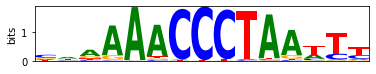

In [12]:
#this one is a good example (TFBS)
min_pos, max_pos = 3582589, 3582603

logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
plt.savefig("logo_tfbs.svg", bbox_inches="tight")

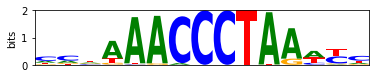

In [17]:
# plotting known motif
# http://planttfdb.gao-lab.org/tf.php?sp=Ath&did=AT1G72740.1
# http://planttfdb.gao-lab.org/motif/Ath/AT1G72740.meme
string = """
0.213058	  0.529210	  0.079038	  0.178694
0.237113	  0.546392	  0.116838	  0.099656
0.202749	  0.158076	  0.175258	  0.463918
0.735395	  0.010309	  0.075601	  0.178694
0.969072	  0.010309	  0.006873	  0.013746
0.969072	  0.000000	  0.030928	  0.000000
0.034364	  0.965636	  0.000000	  0.000000
0.000000	  1.000000	  0.000000	  0.000000
0.000000	  1.000000	  0.000000	  0.000000
0.000000	  0.000000	  0.000000	  1.000000
0.993127	  0.000000	  0.003436	  0.003436
0.831615	  0.000000	  0.168385	  0.000000
0.474227	  0.140893	  0.006873	  0.378007
0.030928	  0.443299	  0.054983	  0.470790
0.127148	  0.539519	  0.092784	  0.240550
"""
true_motif = pd.read_csv(StringIO(string), sep="\t", header=None, names=["A", "C", "G", "T"])
logomaker.Logo(
    logomaker.transform_matrix(true_motif, from_type="probability", to_type="information"),
    figsize=figsize
)
plt.ylabel(ylabel)
plt.xticks([], [])
#plt.tight_layout()
plt.savefig("logo_tfbs_true.svg", bbox_inches="tight")

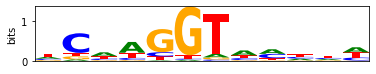

In [13]:
# splice donor
min_pos, max_pos = 3510975, 3510986
logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
plt.savefig("logo_splice_donor.svg", bbox_inches="tight")

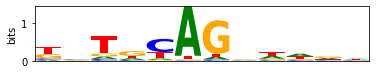

In [15]:
# splice donor
min_pos, max_pos = 3511464,3511475
logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
plt.savefig("logo_splice_acceptor.svg", bbox_inches="tight")

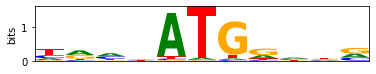

In [16]:
# start codon
min_pos, max_pos = 3598954, 3598964
logomaker.Logo(
    logomaker.transform_matrix(df.loc[min_pos:max_pos, nucleotides], from_type="probability", to_type="information"),
    figsize=figsize,
)
plt.ylabel(ylabel)
plt.xticks([], [])
plt.savefig("logo_start_codon.svg", bbox_inches="tight")

In [10]:
#plot_motif(3567383, 3567391)

Reference seq:  CTTCCATGGAAGA


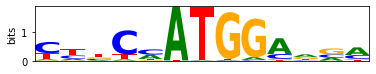

In [32]:
plot_motif(3502138, 3502150, save_to="results/plots/motif_start_codon_3502138.svg")

In [17]:
#plot_motif(3510402, 3510414)

Reference seq:  AAAAAATGGTGAC


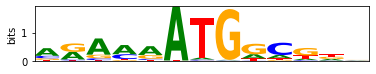

In [33]:
plot_motif(3524790, 3524802, save_to="results/plots/motif_start_codon_3524790.svg")

Reference seq:  CTTTCATGGCGGA


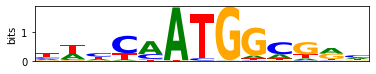

In [27]:
plot_motif(3542314, 3542326, save_to="results/plots/start_codon_3542314.svg")

Reference seq:  CAGAGATGAGTTT


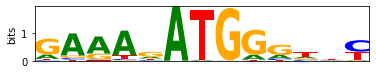

In [25]:
plot_motif(3545337, 3545349, save_to="results/plots/start_codon_3545337.svg")

Reference seq:  AAAAGATGTTTGC


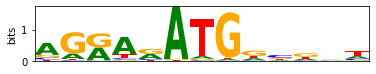

In [26]:
plot_motif(3550768, 3550780, save_to="results/plots/start_codon_3550768.svg")

In [54]:
funtfbs = pd.read_csv("TFBS_from_FunTFBS_genome-wide_Ath.gff", sep="\t", header=None, names=["chromosome", "source1", "source2", "start", "end", "score", "strand", "unknown", "annotation"], usecols=["chromosome", "start", "end", "strand", "annotation"])
funtfbs

,chromosome,start,end,strand,annotation
0,Chr1,1064,1081,-,Name=AT5G62470;ID=AT5G62470_1;correlation=0.53...
1,Chr1,1070,1080,-,Name=AT3G08500;ID=AT3G08500_2;correlation=0.66...
2,Chr1,1428,1438,+,Name=AT5G67450;ID=AT5G67450_3;correlation=0.74...
3,Chr1,2982,2995,-,Name=AT5G41570;ID=AT5G41570_4;correlation=0.53...
4,Chr1,4047,4066,+,Name=AT2G01570;ID=AT2G01570_5;correlation=0.51...
...,...,...,...,...,...
327937,ChrM,361893,361907,-,Name=AT5G51190;ID=AT5G51190_327938;correlation...
327938,ChrM,361895,361909,-,Name=AT5G67000;ID=AT5G67000_327939;correlation...
327939,ChrM,361896,361910,-,Name=AT4G34410;ID=AT4G34410_327940;correlation...
327940,ChrM,361898,361912,+,Name=AT5G07310;ID=AT5G07310_327941;correlation...


Reference seq:  CCTTTTTGGGC


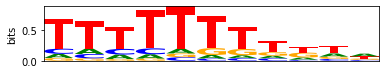

In [9]:
plot_motif(5962296, 5962306)

Reference seq:  GCAAATTTTGGT


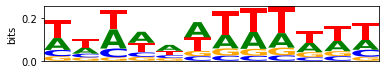

In [12]:
plot_motif(5961967, 5961978)

Reference seq:  CCTATTTTTAGT


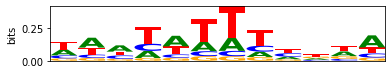

In [15]:
plot_motif(5961859, 5961870)

## Grouping by known TFBS

In [55]:
funtfbs = funtfbs.query("chromosome == 'Chr5' and start >= 3500000 and end <= 3600000")
funtfbs

,chromosome,start,end,strand,annotation
267053,Chr5,3500583,3500602,-,Name=AT1G71450;ID=AT1G71450_267054;correlation...
267054,Chr5,3500584,3500604,+,Name=AT2G40340;ID=AT2G40340_267055;correlation...
267055,Chr5,3502186,3502206,+,Name=AT4G27950;ID=AT4G27950_267056;correlation...
267056,Chr5,3502188,3502206,-,Name=AT5G25190;ID=AT5G25190_267057;correlation...
267057,Chr5,3502239,3502254,+,Name=AT1G19040;ID=AT1G19040_267058;correlation...
...,...,...,...,...,...
267271,Chr5,3596606,3596626,+,Name=AT3G20310;ID=AT3G20310_267272;correlation...
267272,Chr5,3597413,3597428,+,Name=AT4G01500;ID=AT4G01500_267273;correlation...
267273,Chr5,3597445,3597454,-,Name=AT2G17180;ID=AT2G17180_267274;correlation...
267274,Chr5,3597445,3597454,+,Name=AT2G17180;ID=AT2G17180_267275;correlation...


In [56]:
funtfbs["TF"] = funtfbs.annotation.str.split(";").str[0].str.split("=").str[1]
funtfbs["seq"] = funtfbs.annotation.str.split(";").str[4].str.split("=").str[1]
funtfbs.drop(columns=["annotation"], inplace=True)
funtfbs

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/scratch/projects/fc_songlab/gbenegas/.local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be s

,chromosome,start,end,strand,TF,seq
267053,Chr5,3500583,3500602,-,AT1G71450,CACCTCCAGCTACACAGACA
267054,Chr5,3500584,3500604,+,AT2G40340,GTCTGTGTAGCTGGAGGTGCA
267055,Chr5,3502186,3502206,+,AT4G27950,GCTGCACCACCGTTGACGGCG
267056,Chr5,3502188,3502206,-,AT5G25190,CGCCGTCAACGGTGGTGCA
267057,Chr5,3502239,3502254,+,AT1G19040,AGCCTTGTGCTTCAAG
...,...,...,...,...,...,...
267271,Chr5,3596606,3596626,+,AT3G20310,TCCTCCTCCTCACCTCCTCCA
267272,Chr5,3597413,3597428,+,AT4G01500,TCTCTTCAGGTAAATT
267273,Chr5,3597445,3597454,-,AT2G17180,CGCAGCTGAG
267274,Chr5,3597445,3597454,+,AT2G17180,CTCAGCTGCG


In [57]:
funtfbs["median_perplexity"] = funtfbs.apply(lambda row: df.loc[row.start:row.end, "perplexity"].median(), axis=1)
funtfbs.sort_values("median_perplexity").head(20)

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,chromosome,start,end,strand,TF,seq,median_perplexity
267267,Chr5,3596382,3596396,-,AT3G24050,ATGATGATGATGATA,1.290498
267197,Chr5,3563520,3563539,+,AT5G17430,AAAAAAAAAAAAAAAAAAAA,1.311138
267192,Chr5,3558544,3558558,+,AT1G49480,CAAAAAAAAAAAAAA,1.332810
267193,Chr5,3558545,3558559,+,AT1G49480,AAAAAAAAAAAAAAA,1.332810
267194,Chr5,3558546,3558560,+,AT1G49480,AAAAAAAAAAAAAAA,1.332810
267191,Chr5,3558543,3558557,+,AT1G49480,ACAAAAAAAAAAAAA,1.382530
267190,Chr5,3558542,3558562,-,AT3G55370,TTTTTTTTTTTTTTTTTTGTT,1.411056
267198,Chr5,3563525,3563545,-,AT2G45660,TTCGTGTTTTTTTTTTTTTTT,1.450468
267204,Chr5,3565965,3565983,-,AT1G72050,CTTCTTCTTCTTCTTCTTT,1.594197
267164,Chr5,3530102,3530121,-,AT5G17430,AAAAAAAAAAAAAAAAGAAG,1.653542


In [65]:
funtfbs.query('strand == "+"').drop_duplicates("start").drop_duplicates("end").sort_values("median_perplexity").head(50)

,chromosome,start,end,strand,TF,seq,median_perplexity
267197,Chr5,3563520,3563539,+,AT5G17430,AAAAAAAAAAAAAAAAAAAA,1.311138
267194,Chr5,3558546,3558560,+,AT1G49480,AAAAAAAAAAAAAAA,1.332810
267192,Chr5,3558544,3558558,+,AT1G49480,CAAAAAAAAAAAAAA,1.332810
267193,Chr5,3558545,3558559,+,AT1G49480,AAAAAAAAAAAAAAA,1.332810
267191,Chr5,3558543,3558557,+,AT1G49480,ACAAAAAAAAAAAAA,1.382530
267201,Chr5,3564538,3564552,+,AT1G49480,AAAAAAAAAAAAAAG,1.753449
267200,Chr5,3564537,3564551,+,AT1G49480,AAAAAAAAAAAAAAA,1.753449
267199,Chr5,3564536,3564550,+,AT1G49480,GAAAAAAAAAAAAAA,1.753449
267145,Chr5,3523639,3523653,+,AT1G49480,CCAAAAAAAAAAAAA,1.777528
267233,Chr5,3582590,3582604,+,AT1G72740,CAAAAACCCTAATTT,1.824076


## Saving bigwig for visualization in UCSC Genome Browser

In [47]:
with open(f'wig_perplexity_{coordinates}.txt', 'a') as file:
    file.write(f'fixedStep  chrom=Chr5 start={start+1}  step=1\n')  # check Chr vs. chr
    df.to_csv(file, columns=["perplexity"], header=False, index=False)

In [48]:
!head wig*

fixedStep  chrom=Chr5 start=3500001  step=1
3.6080182634160574
7.212613414699377
2.8532721019041967
2.4459678935679694
3.697120494332242
1.8633079633266865
3.867195624206221
1.6823798226034428
6.682676612531764


In [53]:
!ls wig*

wigToBigWig  wig_perplexity_Chr5:3500000-3600000.txt


In [49]:
!wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/wigToBigWig
!chmod +x wigToBigWig

--2022-06-18 13:31:03--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/wigToBigWig
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9527800 (9.1M)
Saving to: 'wigToBigWig'

100%[======================================>] 9,527,800   5.19MB/s   in 1.7s   

2022-06-18 13:31:04 (5.19 MB/s) - 'wigToBigWig' saved [9527800/9527800]



In [57]:
!./wigToBigWig wig_perplexity_Chr5:3500000-3600000.txt ../../data/chromatin/chrom.sizes wig_perplexity_Chr5:3500000-3600000.bw

## Rolling window calculation

In [291]:
#!wget http://plantregmap.gao-lab.org/download_ftp.php?filepath=08-download/Arabidopsis_thaliana/binding/TFBS_from_motif_CE_inProm_Ath.gff -O TFBS_from_motif_CE_inProm_Ath.gff 
#!wget http://plantregmap.gao-lab.org/download_ftp.php?filepath=08-download/Arabidopsis_thaliana/binding/TFBS_from_FunTFBS_inProm_Ath.gff -O TFBS_from_FunTFBS_inProm_Ath.gff
#!wget http://plantregmap.gao-lab.org/download_ftp.php?filepath=08-download/Arabidopsis_thaliana/binding/TFBS_from_motif_CE_genome-wide_Ath.gff -O TFBS_from_motif_CE_genome-wide_Ath.gff
#!wget http://plantregmap.gao-lab.org/download_ftp.php?filepath=08-download/Arabidopsis_thaliana/binding/TFBS_from_FunTFBS_genome-wide_Ath.gff -O TFBS_from_FunTFBS_genome-wide_Ath.gff

In [295]:
funtfbs = pd.read_csv(
    #"TFBS_from_FunTFBS_inProm_Ath.gff",
    "TFBS_from_FunTFBS_genome-wide_Ath.gff",
    sep="\t", header=None, names=["chrom", "source1", "source2", "start", "end", "score", "strand", "unknown", "annotation"], usecols=["chrom", "start", "end", "strand", "annotation"])
funtfbs = funtfbs[funtfbs.chrom=="Chr5"]
funtfbs.chrom.replace({"Chr5": "5"}, inplace=True)
funtfbs

,chrom,start,end,strand,annotation
253547,5,5000,5014,+,Name=AT5G19790;ID=AT5G19790_253548;correlation...
253548,5,5003,5017,-,Name=AT5G05550;ID=AT5G05550_253549;correlation...
253549,5,5241,5255,-,Name=AT1G49480;ID=AT1G49480_253550;correlation...
253550,5,8350,8364,+,Name=AT1G72740;ID=AT1G72740_253551;correlation...
253551,5,9252,9265,-,Name=AT1G76890;ID=AT1G76890_253552;correlation...
...,...,...,...,...,...
327176,5,26970132,26970150,+,Name=AT1G72050;ID=AT1G72050_327177;correlation...
327177,5,26970467,26970481,+,Name=AT3G24050;ID=AT3G24050_327178;correlation...
327178,5,26970687,26970698,+,Name=AT2G21900;ID=AT2G21900_327179;correlation...
327179,5,26972171,26972191,+,Name=AT2G40340;ID=AT2G40340_327180;correlation...


In [293]:
motif_ce = pd.read_csv(
    #"TFBS_from_motif_CE_inProm_Ath.gff",
    "TFBS_from_motif_CE_genome-wide_Ath.gff",
    sep="\t", header=None, names=["chrom", "source1", "source2", "start", "end", "score", "strand", "unknown", "annotation"], usecols=["chrom", "start", "end", "strand", "annotation"])
motif_ce = motif_ce[motif_ce.chrom=="Chr5"]
motif_ce.chrom.replace({"Chr5": "5"}, inplace=True)
motif_ce

,chrom,start,end,strand,annotation
1425748,5,1401,1421,+,Name=AT5G63090;ID=AT5G63090_1425749;sequence=T...
1425749,5,1406,1420,+,Name=AT3G60530;ID=AT3G60530_1425750;sequence=C...
1425750,5,1408,1420,-,Name=AT5G25830;ID=AT5G25830_1425751;sequence=G...
1425751,5,1413,1433,+,Name=AT5G63090;ID=AT5G63090_1425752;sequence=T...
1425752,5,1641,1655,-,Name=AT1G51220;ID=AT1G51220_1425753;sequence=T...
...,...,...,...,...,...
1860294,5,26970474,26970494,-,Name=AT1G65620;ID=AT1G65620_1860295;sequence=C...
1860295,5,26970475,26970489,+,Name=AT5G18090;ID=AT5G18090_1860296;sequence=G...
1860296,5,26970526,26970546,+,Name=AT1G12630;ID=AT1G12630_1860297;sequence=C...
1860297,5,26970527,26970547,+,Name=AT1G03800;ID=AT1G03800_1860298;sequence=G...


In [296]:
gtf = pd.read_csv(
    "Arabidopsis_thaliana.TAIR10.54.chromosome.5.gff3.gz",
    sep='\t', header=None, comment="#",
    names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'],
)
gtf.chrom = gtf.chrom.astype(str)
gtf = gtf[gtf.chrom.isin(["Chr5", "chr5", "5"])]
gtf

,chrom,source,feature,start,end,score,strand,frame,attribute
0,5,TAIR10,chromosome,1,26975502,.,.,.,"ID=chromosome:5;Alias=Chr5,CP002688.1,NC_003076.8"
1,5,araport11,ncRNA_gene,2,303,.,+,.,ID=gene:AT5G00730;Name=AT5G00730;biotype=lncRN...
2,5,araport11,lnc_RNA,2,303,.,+,.,ID=transcript:AT5G00730.1;Parent=gene:AT5G0073...
3,5,araport11,exon,2,303,.,+,.,Parent=transcript:AT5G00730.1;Name=AT5G00730.1...
4,5,araport11,gene,995,5156,.,-,.,ID=gene:AT5G01010;Name=AT5G01010;biotype=prote...
...,...,...,...,...,...,...,...,...,...
180526,5,araport11,lnc_RNA,26971389,26971689,.,+,.,ID=transcript:AT5G09955.1;Parent=gene:AT5G0995...
180527,5,araport11,exon,26971389,26971689,.,+,.,Parent=transcript:AT5G09955.1;Name=AT5G09955.1...
180528,5,araport11,ncRNA_gene,26972177,26972644,.,-,.,ID=gene:AT5G09965;Name=AT5G09965;biotype=lncRN...
180529,5,araport11,lnc_RNA,26972177,26972644,.,-,.,ID=transcript:AT5G09965.1;Parent=gene:AT5G0996...


In [297]:
gtf.feature.value_counts()

exon               71613
CDS                65591
five_prime_UTR     12839
three_prime_UTR    11015
mRNA               10996
gene                6332
ncRNA_gene          1030
lnc_RNA              775
tRNA                 123
miRNA                 76
snoRNA                61
ncRNA                 52
snRNA                 27
chromosome             1
Name: feature, dtype: int64

In [298]:
gene_spans = bf.merge(gtf[gtf.feature.isin(["gene", "ncRNA_gene"])])
gene_spans

,chrom,start,end,n_intervals
0,5,2,303,1
1,5,995,5156,1
2,5,5256,5907,2
3,5,5917,8467,1
4,5,9780,16236,2
...,...,...,...,...
6119,5,26966885,26967079,1
6120,5,26967378,26969400,1
6121,5,26969516,26970668,1
6122,5,26971389,26971689,1


In [346]:
gtf_mRNA = gtf[gtf.feature=="mRNA"].copy()
gtf_mRNA["transcript_id"] = gtf_mRNA.attribute.str.extract(r'transcript:([^;]*);')
mRNA_boundaries = gtf_mRNA.groupby("transcript_id").agg({"chrom": "first", "start": "min", "end": "max", "strand": "first"}).reset_index()
# TODO: to simplify can consider positive strand only? probably not.

promoter = mRNA_boundaries.copy()
prom_up = 600
prom_down = 0#100  # this is not really working, it's always 0 because we later substract gene regions
promoter.start, promoter.end = zip(*promoter.apply(lambda row: (row.start-prom_up, row.start+prom_down) if row.strand=="+" else (row.end-prom_down, row.end+prom_up), axis=1))
promoter = bf.merge(promoter)
promoter

,chrom,start,end,n_intervals
0,5,4739,5756,6
1,5,5801,6507,2
2,5,8467,9067,1
3,5,9180,9869,3
4,5,16236,16836,1
...,...,...,...,...
5761,5,26960399,26960999,1
5762,5,26963638,26964336,2
5763,5,26966010,26966610,1
5764,5,26969400,26970000,1


In [347]:
regions = bf.subtract(promoter, gene_spans)
regions

,chrom,start,end,n_intervals
0,5,5156,5256,6.0
1,5,5907,5917,2.0
2,5,8467,9067,1.0
3,5,9180,9780,3.0
4,5,16236,16836,1.0
...,...,...,...,...
5489,5,26960399,26960904,1.0
5490,5,26963736,26964336,2.0
5491,5,26966010,26966610,1.0
5492,5,26969400,26969516,1.0


In [348]:
repeats = pd.read_csv("../../data/mlm/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats = repeats.query('chrom == "Chr5"')
repeats.chrom = "5"
repeats = bf.merge(repeats)
repeats

,chrom,start,end,n_intervals
0,5,10,74,1
1,5,359,396,2
2,5,932,997,1
3,5,5248,5289,1
4,5,6183,6213,1
...,...,...,...,...
13593,5,26965927,26965975,1
13594,5,26966363,26966387,1
13595,5,26970597,26970616,1
13596,5,26971035,26971072,1


In [349]:
regions = bf.subtract(regions, repeats)
regions

,chrom,start,end,n_intervals
0,5,5156,5248,6.0
1,5,5907,5917,2.0
2,5,8467,9067,1.0
3,5,9180,9780,3.0
4,5,16236,16836,1.0
...,...,...,...,...
7049,5,26966010,26966363,1.0
7050,5,26966387,26966610,1.0
7051,5,26969400,26969516,1.0
7052,5,26970668,26971035,1.0


In [350]:
df["chrom"] = df.chromosome
df.chrom.replace({"Chr5": "5"}, inplace=True)
df["start"] = df.pos
df["end"] = df.start + 1
df

,pos,chromosome,A,C,G,T,ref_nuc,llr_A,llr_C,llr_G,...,ref_1hot_C,ref_1hot_G,ref_1hot_T,cross_entropy,entropy,cross_perplexity,perplexity,chrom,start,end
0,3500000,Chr5,0.344579,0.106808,0.278123,0.270490,A,0.000000,-1.171289,-0.214262,...,0.0,0.0,0.0,1.537093,1.898022,2.902092,3.727017,5,3500000,3500001
1,3500001,Chr5,0.410754,0.156371,0.300011,0.132865,C,0.965767,0.000000,0.651589,...,1.0,0.0,0.0,2.676959,1.853854,6.395065,3.614645,5,3500001,3500002
2,3500002,Chr5,0.401194,0.096803,0.149774,0.352229,A,0.000000,-1.421768,-0.985316,...,0.0,0.0,0.0,1.317628,1.795238,2.492560,3.470726,5,3500002,3500003
3,3500003,Chr5,0.222095,0.148082,0.357351,0.272472,G,-0.475614,-0.880956,0.000000,...,0.0,1.0,0.0,1.484584,1.931784,2.798366,3.815267,5,3500003,3500004
4,3500004,Chr5,0.224391,0.330020,0.147175,0.298414,C,-0.385763,0.000000,-0.807531,...,1.0,0.0,0.0,1.599375,1.939060,3.030121,3.834557,5,3500004,3500005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3599995,Chr5,0.312765,0.091956,0.253395,0.341884,C,1.224146,0.000000,1.013643,...,1.0,0.0,0.0,3.442917,1.872295,10.874797,3.661146,5,3599995,3599996
99996,3599996,Chr5,0.263469,0.153526,0.392654,0.190351,G,-0.398993,-0.939062,0.000000,...,0.0,1.0,0.0,1.348669,1.907162,2.546770,3.750705,5,3599996,3599997
99997,3599997,Chr5,0.231608,0.446558,0.164874,0.156959,T,0.389061,1.045583,0.049197,...,0.0,0.0,1.0,2.671538,1.856221,6.371079,3.620579,5,3599997,3599998
99998,3599998,Chr5,0.194339,0.241565,0.342542,0.221555,T,-0.131063,0.086468,0.435724,...,0.0,0.0,1.0,2.174266,1.965551,4.513561,3.905618,5,3599998,3599999


In [444]:
df_regions = bf.count_overlaps(df, regions)
df_regions = df_regions[df_regions["count"]==1]
df_regions

,pos,chromosome,A,C,G,T,ref_nuc,llr_A,llr_C,llr_G,...,ref_1hot_G,ref_1hot_T,cross_entropy,entropy,cross_perplexity,perplexity,chrom,start,end,count
1492,3501492,Chr5,0.380149,0.149256,0.163125,0.307470,C,0.934903,0.000000,0.088854,...,0.0,0.0,2.744141,1.889906,6.699909,3.706111,5,3501492,3501493,1
1493,3501493,Chr5,0.301023,0.128252,0.174241,0.396484,A,0.000000,-0.853186,-0.546747,...,0.0,0.0,1.732056,1.869800,3.322010,3.654819,5,3501493,3501494,1
1494,3501494,Chr5,0.415622,0.180079,0.095200,0.309098,T,0.296117,-0.540263,-1.177679,...,0.0,1.0,1.693862,1.818413,3.235216,3.526930,5,3501494,3501495,1
1495,3501495,Chr5,0.342701,0.127877,0.151682,0.377740,A,0.000000,-0.985794,-0.815074,...,0.0,0.0,1.544976,1.852155,2.917992,3.610391,5,3501495,3501496,1
1496,3501496,Chr5,0.383258,0.188740,0.087656,0.340346,A,0.000000,-0.708335,-1.475284,...,0.0,0.0,1.383614,1.821362,2.609211,3.534146,5,3501496,3501497,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98921,3598921,Chr5,0.309480,0.163671,0.313766,0.213082,A,0.000000,-0.637035,0.013755,...,0.0,0.0,1.692081,1.951007,3.231225,3.866444,5,3598921,3598922,1
98922,3598922,Chr5,0.202914,0.151820,0.197753,0.447513,A,0.000000,-0.290083,-0.025759,...,0.0,0.0,2.301063,1.861308,4.928208,3.633370,5,3598922,3598923,1
98923,3598923,Chr5,0.333113,0.260582,0.137002,0.269303,T,0.212647,-0.032917,-0.675841,...,0.0,1.0,1.892700,1.936462,3.713295,3.827658,5,3598923,3598924,1
98924,3598924,Chr5,0.169680,0.373474,0.128009,0.328837,T,-0.661649,0.127284,-0.943463,...,0.0,1.0,1.604554,1.872178,3.041017,3.660849,5,3598924,3598925,1


In [445]:
df_regions = df_regions.set_index("pos", drop=False)

In [446]:
df_regions.pos

pos
3501492    3501492
3501493    3501493
3501494    3501494
3501495    3501495
3501496    3501496
            ...   
3598921    3598921
3598922    3598922
3598923    3598923
3598924    3598924
3598925    3598925
Name: pos, Length: 10225, dtype: int64

In [468]:
window_size = 10
large_window_size = 50
min_coverage = 8
col = "entropy"
#col = "cross_entropy"

def local_median(row, window_size):
    x = df_regions.loc[row.name-window_size//2:row.name+window_size//2]
    #print(len(x))
    #raise Exception("debug")
    if len(x) < window_size:
        return np.nan
    else:
        return x[col].median() 

In [448]:
large_win_entropy = df_regions.apply(lambda row: local_median(row, large_window_size), axis=1).dropna().to_frame()
large_win_entropy.rename(columns={0: "entropy"}, inplace=True)
large_win_entropy["chrom"] = df_regions.chrom.iloc[0]
large_win_entropy["start"] = large_win_entropy.index - window_size//2
large_win_entropy["end"] = large_win_entropy.index + window_size//2
large_win_entropy

,entropy,chrom,start,end
pos,,,,
3501516,1.869885,5,3501511,3501521
3501517,1.869800,5,3501512,3501522
3501518,1.869800,5,3501513,3501523
3501519,1.857012,5,3501514,3501524
3501520,1.857012,5,3501515,3501525
...,...,...,...,...
3598897,1.872734,5,3598892,3598902
3598898,1.875325,5,3598893,3598903
3598899,1.875325,5,3598894,3598904


<AxesSubplot:>

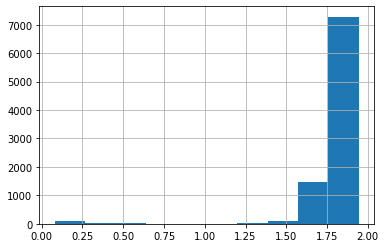

In [449]:
# I think large windows of low entropy represent undetected repetitive elements, so we
# will filter them out
large_win_entropy.entropy.hist()

In [450]:
df_regions

,pos,chromosome,A,C,G,T,ref_nuc,llr_A,llr_C,llr_G,...,ref_1hot_G,ref_1hot_T,cross_entropy,entropy,cross_perplexity,perplexity,chrom,start,end,count
pos,,,,,,,,,,,,,,,,,,,,,
3501492,3501492,Chr5,0.380149,0.149256,0.163125,0.307470,C,0.934903,0.000000,0.088854,...,0.0,0.0,2.744141,1.889906,6.699909,3.706111,5,3501492,3501493,1
3501493,3501493,Chr5,0.301023,0.128252,0.174241,0.396484,A,0.000000,-0.853186,-0.546747,...,0.0,0.0,1.732056,1.869800,3.322010,3.654819,5,3501493,3501494,1
3501494,3501494,Chr5,0.415622,0.180079,0.095200,0.309098,T,0.296117,-0.540263,-1.177679,...,0.0,1.0,1.693862,1.818413,3.235216,3.526930,5,3501494,3501495,1
3501495,3501495,Chr5,0.342701,0.127877,0.151682,0.377740,A,0.000000,-0.985794,-0.815074,...,0.0,0.0,1.544976,1.852155,2.917992,3.610391,5,3501495,3501496,1
3501496,3501496,Chr5,0.383258,0.188740,0.087656,0.340346,A,0.000000,-0.708335,-1.475284,...,0.0,0.0,1.383614,1.821362,2.609211,3.534146,5,3501496,3501497,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598921,3598921,Chr5,0.309480,0.163671,0.313766,0.213082,A,0.000000,-0.637035,0.013755,...,0.0,0.0,1.692081,1.951007,3.231225,3.866444,5,3598921,3598922,1
3598922,3598922,Chr5,0.202914,0.151820,0.197753,0.447513,A,0.000000,-0.290083,-0.025759,...,0.0,0.0,2.301063,1.861308,4.928208,3.633370,5,3598922,3598923,1
3598923,3598923,Chr5,0.333113,0.260582,0.137002,0.269303,T,0.212647,-0.032917,-0.675841,...,0.0,1.0,1.892700,1.936462,3.713295,3.827658,5,3598923,3598924,1


In [452]:
df_regions = bf.subtract(df_regions, large_win_entropy.query('entropy < 1.0'))
df_regions.pos = df_regions.pos.astype(int)
df_regions.set_index("pos", drop=False, inplace=True)
df_regions

,chrom,start,end,pos,chromosome,A,C,G,T,ref_nuc,...,llr_T,ref_1hot_A,ref_1hot_C,ref_1hot_G,ref_1hot_T,cross_entropy,entropy,cross_perplexity,perplexity,count
pos,,,,,,,,,,,,,,,,,,,,,
3501492,5,3501492,3501493,3501492,Chr5,0.380149,0.149256,0.163125,0.307470,C,...,0.722717,0.0,1.0,0.0,0.0,2.744141,1.889906,6.699909,3.706111,1.0
3501493,5,3501493,3501494,3501493,Chr5,0.301023,0.128252,0.174241,0.396484,A,...,0.275451,1.0,0.0,0.0,0.0,1.732056,1.869800,3.322010,3.654819,1.0
3501494,5,3501494,3501495,3501494,Chr5,0.415622,0.180079,0.095200,0.309098,T,...,0.000000,0.0,0.0,0.0,1.0,1.693862,1.818413,3.235216,3.526930,1.0
3501495,5,3501495,3501496,3501495,Chr5,0.342701,0.127877,0.151682,0.377740,A,...,0.097346,1.0,0.0,0.0,0.0,1.544976,1.852155,2.917992,3.610391,1.0
3501496,5,3501496,3501497,3501496,Chr5,0.383258,0.188740,0.087656,0.340346,A,...,-0.118745,1.0,0.0,0.0,0.0,1.383614,1.821362,2.609211,3.534146,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3598921,5,3598921,3598922,3598921,Chr5,0.309480,0.163671,0.313766,0.213082,A,...,-0.373215,1.0,0.0,0.0,0.0,1.692081,1.951007,3.231225,3.866444,1.0
3598922,5,3598922,3598923,3598922,Chr5,0.202914,0.151820,0.197753,0.447513,A,...,0.790925,1.0,0.0,0.0,0.0,2.301063,1.861308,4.928208,3.633370,1.0
3598923,5,3598923,3598924,3598923,Chr5,0.333113,0.260582,0.137002,0.269303,T,...,0.000000,0.0,0.0,0.0,1.0,1.892700,1.936462,3.713295,3.827658,1.0


In [469]:
win_entropy = df_regions.apply(lambda row: local_median(row, window_size), axis=1).dropna().to_frame()
win_entropy.rename(columns={0: "entropy"}, inplace=True)
win_entropy["bin"] = win_entropy.index // window_size
win_entropy["chrom"] = df_regions.chrom.iloc[0]
win_entropy["start"] = win_entropy.index - window_size//2
win_entropy["end"] = win_entropy.index + window_size//2
win_entropy

,entropy,bin,chrom,start,end
pos,,,,,
3501496,1.843604,350149,5,3501491,3501501
3501497,1.851436,350149,5,3501492,3501502
3501498,1.835053,350149,5,3501493,3501503
3501499,1.821362,350149,5,3501494,3501504
3501500,1.835053,350150,5,3501495,3501505
...,...,...,...,...,...
3598917,1.919810,359891,5,3598912,3598922
3598918,1.919810,359891,5,3598913,3598923
3598919,1.911061,359891,5,3598914,3598924


In [470]:
win_entropy = win_entropy.sort_values("entropy")
#win_entropy = win_entropy.drop_duplicates("bin") # this is a bad idea
win_entropy

,entropy,bin,chrom,start,end
pos,,,,,
3524443,0.467481,352444,5,3524438,3524448
3524444,0.467481,352444,5,3524439,3524449
3524445,0.467481,352444,5,3524440,3524450
3595100,0.506880,359510,5,3595095,3595105
3595097,0.506880,359509,5,3595092,3595102
...,...,...,...,...,...
3509656,1.964464,350965,5,3509651,3509661
3509657,1.964464,350965,5,3509652,3509662
3544946,1.967080,354494,5,3544941,3544951


<AxesSubplot:>

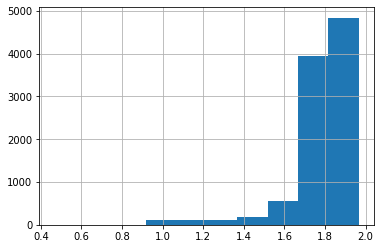

In [471]:
win_entropy.entropy.hist()

In [472]:
win_entropy = bf.coverage(win_entropy, funtfbs)
win_entropy["funtfbs"] = (win_entropy.coverage >= min_coverage)
win_entropy.drop(columns="coverage", inplace=True)
win_entropy

,entropy,bin,chrom,start,end,funtfbs
0,0.467481,352444,5,3524438,3524448,False
1,0.467481,352444,5,3524439,3524449,False
2,0.467481,352444,5,3524440,3524450,False
3,0.506880,359510,5,3595095,3595105,False
4,0.506880,359509,5,3595092,3595102,False
...,...,...,...,...,...,...
9853,1.964464,350965,5,3509651,3509661,False
9854,1.964464,350965,5,3509652,3509662,False
9855,1.967080,354494,5,3544941,3544951,False
9856,1.967152,350965,5,3509649,3509659,False


In [473]:
win_entropy = bf.coverage(win_entropy, motif_ce)
win_entropy["motif_ce"] = (win_entropy.coverage >= min_coverage)
win_entropy.drop(columns="coverage", inplace=True)
win_entropy

,entropy,bin,chrom,start,end,funtfbs,motif_ce
0,0.467481,352444,5,3524438,3524448,False,True
1,0.467481,352444,5,3524439,3524449,False,True
2,0.467481,352444,5,3524440,3524450,False,True
3,0.506880,359510,5,3595095,3595105,False,False
4,0.506880,359509,5,3595092,3595102,False,False
...,...,...,...,...,...,...,...
9853,1.964464,350965,5,3509651,3509661,False,False
9854,1.964464,350965,5,3509652,3509662,False,False
9855,1.967080,354494,5,3544941,3544951,False,False
9856,1.967152,350965,5,3509649,3509659,False,False


In [474]:
win_entropy.funtfbs.value_counts()

False    9674
True      184
Name: funtfbs, dtype: int64

In [475]:
win_entropy.motif_ce.value_counts()

False    9538
True      320
Name: motif_ce, dtype: int64

In [476]:
win_entropy.head(50)

,entropy,bin,chrom,start,end,funtfbs,motif_ce
0,0.467481,352444,5,3524438,3524448,False,True
1,0.467481,352444,5,3524439,3524449,False,True
2,0.467481,352444,5,3524440,3524450,False,True
3,0.506880,359510,5,3595095,3595105,False,False
4,0.506880,359509,5,3595092,3595102,False,False
5,0.506880,359509,5,3595094,3595104,False,False
6,0.506880,359509,5,3595093,3595103,False,False
7,0.634714,359509,5,3595091,3595101,False,False
8,0.813607,353581,5,3535810,3535820,False,False
9,0.813607,353581,5,3535809,3535819,False,False


In [477]:
win_entropy["Entropy group"] = "High"
#win_entropy.loc[np.arange(100), "Entropy group"] = "Low"
win_entropy.loc[win_entropy.entropy < 1.0, "Entropy group"] = "Low"
win_entropy["Entropy group"].value_counts()

High    9813
Low       45
Name: Entropy group, dtype: int64

In [478]:
win_entropy["Putative TFBS"] = win_entropy.funtfbs | win_entropy.motif_ce
win_entropy["% putative TFBS"] = 100 * win_entropy["Putative TFBS"]

<AxesSubplot:xlabel='Entropy group', ylabel='% putative TFBS'>

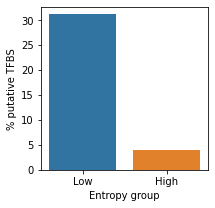

In [479]:
plt.figure(figsize=(3,3))
sns.barplot(
    data=win_entropy,
    x="Entropy group",
    y="% putative TFBS",
    ci=None,
)
# can get p-value with Fisher's exact test
# to get more significance need to expand the region